# Astro Lab Book 2025

In [1]:
import astropy
import numpy as np
import ccdproc as ccdp
from pathlib import Path
from astropy.nddata import CCDData
from astropy.stats import mad_std
import astropy.units as u
import matplotlib.pyplot as plt
import warnings
import glob
import os
import photutils.background as photobg
import photutils.segmentation as photoseg
from astropy.convolution import convolve
from photutils.segmentation import SourceCatalog
from photutils.utils import calc_total_error
import photutils.aperture as photoap
from photutils.background import MedianBackground
from scipy.optimize import curve_fit

warnings.filterwarnings(action='once') #prevents warnings repeating and clogging workspace

In [2]:
biasImg = astropy.nddata.CCDData.read('data/bias/20181101.bias.00000002.fits', unit='adu')
biasimg = np.asarray(biasImg, dtype=np.float64)

def biasavg(biasframe):
    total = 0
    x = len(biasframe)
    y = len(biasframe[0]) #as the array is a square this returns the length of all columns

    for i in range(x):
        for j in range(y):
            total+=biasframe[i][j]

    biasavg = total/(x*y) #mean

    myvar = 0 #filler variable

    for i in range(x):
        for j in range(y):
            myvar+=((biasframe[i][j] - biasavg)**2)

    biasdev = np.sqrt(myvar/(x*y)) #standard deviation

    output = [biasavg, biasdev]
    
    return(output)

biasavg1 = biasavg(biasimg)

print(biasavg1[0])
print(biasavg1[1])

960.1504330039024
8.422060711910369


In [3]:
warnings.filterwarnings('ignore') #this otherwise outputs many, many warnings

calibrated_path_bias = Path('data/bias')
#allbias = ccdp.ImageFileCollection(calibrated_path_bias)
calibrated_biases = glob.glob("data/bias/*.fits")

#calibrated_biases = allbias.files_filtered(imagetyp='Bias Frame', include_path=True)

combined_bias = ccdp.combine(calibrated_biases, #combines all bias frames into my master bias frame
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5, 
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, #the sigma_clip removes any significant outliers from the data
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_bias.meta['combined'] = True

INFO: splitting each image into 11 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


In [4]:
masterbias = np.asarray(combined_bias)

bias = biasavg(masterbias)[0]
read_noise = biasavg(masterbias)[1]

print(bias) #bias
print(read_noise) #read noise

962.9592900923088
5.350563223315935


In [5]:
biasnum = len(calibrated_biases)
biasdev1 = biasavg(biasimg)[1]
biasdevmaster = biasavg(masterbias)[1]

expecteddev = biasdev1 / np.sqrt(biasnum) #what our expected relation gives

print((biasdevmaster - expecteddev)/expecteddev)

0.4205814342237132


In [6]:
#uncalibrated_path_dark = Path('data/dark')
#calibrated_path_dark = Path('data/calibrated_darks')

#alldark = ccdp.ImageFileCollection(uncalibrated_path_dark)
alldark = glob.glob("data/darks/*.fits")

for item in alldark:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    ccd = ccdp.subtract_bias(ccd, combined_bias) #subtracts bias from each dark frame
    file_name = os.path.basename(item)
    ccd.write(Path('data/calibrated_darks') / file_name, overwrite=True) #writes calibrated dark into new folder

In [7]:
#allcalibrateddark = ccdp.ImageFileCollection('data/calibrated_darks')
calibrated_darks = glob.glob("data/calibrated_darks/*.fits")

#calibrated_darks = allcalibrateddark.files_filtered(imagetyp='Dark Frame', include_path=True)

combined_dark = ccdp.combine(calibrated_darks, #combines all dark frames into my master dark frame
                             method='median',  #uses median avg rather than mean                          
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_dark.meta['combined'] = True

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 23 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

In [8]:
dark = np.asarray(combined_dark) #gets the master dark

pixtotal = 0

x = len(dark)
y = len(dark[0]) #as the array is a square this returns the length of all columns

for i in range(x):
    for j in range(y):
        pixtotal+=dark[i][j]

darkcurrentavg = 2.2 * pixtotal/(x*y)

print(f"Dark Current Avg: {darkcurrentavg} e/pix/s") 

Dark Current Avg: 9.393139339485636 e/pix/s


In [11]:
flats_B = glob.glob("data/flat_B/*.flat.*.fits")
flats_R = glob.glob("data/flat_R/*.flat.*.fits")

for item in flats_B:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    ccdp.subtract_bias(ccd, combined_bias)
    file_name = os.path.basename(item)
    ccd.write(Path("data/flat_B_semi-cali") / file_name, overwrite=True)

for item in flats_R:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    ccdp.subtract_bias(ccd, combined_bias)
    file_name = os.path.basename(item)
    ccd.write(Path("data/flat_R_semi-cali") / file_name, overwrite=True)

In [13]:
allflats_B = glob.glob("data/flat_B_semi-cali/*.flat.*.fits")
allflats_R = glob.glob("data/flat_R_semi-cali/*.flat.*.fits")

for item in allflats_B:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time="EXPTIME", exposure_unit=u.second) #CHECK EXPOSURE TIMES
    file_name = os.path.basename(item)
    ccd.write(Path("data/flat_B_cali") / file_name, overwrite=True) #writes calibrated flat frame to new folder

for item in allflats_R:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time="EXPTIME", exposure_unit=u.second) #CHECK EXPOSURE TIMES
    file_name = os.path.basename(item)
    ccd.write(Path("data/flat_R_cali") / file_name, overwrite=True) #writes calibrated flat frame to new folder

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

In [14]:
allcalflats_B = glob.glob("data/flat_B_cali/*.flat.*.fits")
allcalflats_R = glob.glob("data/flat_R_cali/*.flat.*.fits")

for item in allcalflats_B:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    
    total = 0
    mean = 0
    ccdarray = np.asarray(ccd)
    
    for i in range(len(ccdarray)):
        for j in range(len(ccdarray[1])):
            total += ccdarray[i, j]
    
    mean = total / (i*j)

    for i in range(len(ccdarray)):
        for j in range(len(ccdarray[1])):
            ccdarray[i, j] /= mean
    
    ccd = CCDData(ccdarray, unit="adu")
    file_name = os.path.basename(item)
    ccd.write(Path("data/flat_B_norm") / file_name, overwrite=True) #writes normalised flat frame to new folder

for item in allcalflats_R:
    ccd = astropy.nddata.CCDData.read(item, unit='adu')
    
    total = 0
    mean = 0
    ccdarray = np.asarray(ccd)
    
    for i in range(len(ccdarray)):
        for j in range(len(ccdarray[1])):
            total += ccdarray[i, j]
    
    mean = total / (i*j)

    for i in range(len(ccdarray)):
        for j in range(len(ccdarray[1])):
            ccdarray[i, j] /= mean
    
    ccd = CCDData(ccdarray, unit="adu")
    file_name = os.path.basename(item)
    ccd.write(Path("data/flat_R_norm") / file_name, overwrite=True) #writes normalised flat frame to new folder

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

In [15]:
calibrated_flats_R = glob.glob("data/flat_R_norm/*.flat.*.fits")
calibrated_flats_B = glob.glob("data/flat_B_norm/*.flat.*.fits")

combined_flat_R = ccdp.combine(calibrated_flats_R, #combines all normalised flat frames into my master flat frame
                             method='median',  #uses median avg rather than mean                          
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_flat_B = ccdp.combine(calibrated_flats_B, #combines all normalised flat frames into my master flat frame
                             method='median',  #uses median avg rather than mean                          
                             mem_limit=350e6,
                             unit='adu'
                            )

combined_flat_R.meta['combined'] = True
combined_flat_B.meta['combined'] = True

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: splitting each image into 16 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the uni

In [19]:
science_R = glob.glob('data/science_R/*.fits')
science_B = glob.glob('data/science_B/*.fits') 

for frame in science_R:
    
    ccd = astropy.nddata.CCDData.read(frame, unit="adu")
    ccd = ccdp.subtract_bias(ccd, combined_bias) #subtracts master bias from each science frame  
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time='EXPTIME', exposure_unit=u.second, scale=True) #subtracts master dark from each science frame
    file_name = os.path.basename(frame)
    ccd.write(Path("data/science_R_semi-cali") / file_name, overwrite=True) #writes calibrated science frame to new folder

for frame in science_B:
    
    ccd = astropy.nddata.CCDData.read(frame, unit="adu")
    ccd = ccdp.subtract_bias(ccd, combined_bias) #subtracts master bias from each science frame  
    ccd = ccdp.subtract_dark(ccd, combined_dark, exposure_time='EXPTIME', exposure_unit=u.second, scale=True) #subtracts master dark from each science frame
    file_name = os.path.basename(frame)
    ccd.write(Path("data/science_B_semi-cali") / file_name, overwrite=True) #writes calibrated science frame to new folder

In [21]:
semicalibratedscience_R = glob.glob('data/science_R_semi-cali/*.fits')
semicalibratedscience_B = glob.glob('data/science_B_semi-cali/*.fits')

for frame in semicalibratedscience_R:
    
    ccd = astropy.nddata.CCDData.read(frame, unit="adu")
    ccdp.ccd_process(ccd, master_flat=combined_flat_R)
    ccdarray = np.asarray(ccd)
    
    for i in range(len(ccdarray)):
        for j in range(len(ccdarray[1])):
            ccdarray[i, j] *= 2 #doubles exposure time by doubling value in each pixel
    
    ccd = CCDData(ccdarray, unit="adu")
    file_name = os.path.basename(frame)
    
    ccd.write(Path('data/science_R_cali') / file_name, overwrite=True) #writes calibrated science frame to new folder

for frame in semicalibratedscience_B:
    
    ccd = astropy.nddata.CCDData.read(frame, unit="adu")
    ccdp.ccd_process(ccd, master_flat=combined_flat_B)
    ccdarray = np.asarray(ccd)
    
    for i in range(len(ccdarray)):
        for j in range(len(ccdarray[1])):
            ccdarray[i, j] *= 2 #doubles exposure time by doubling value in each pixel
    
    ccd = CCDData(ccdarray, unit="adu")
    file_name = os.path.basename(frame)
    
    ccd.write(Path('data/science_B_cali') / file_name, overwrite=True) #writes calibrated science frame to new folder

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


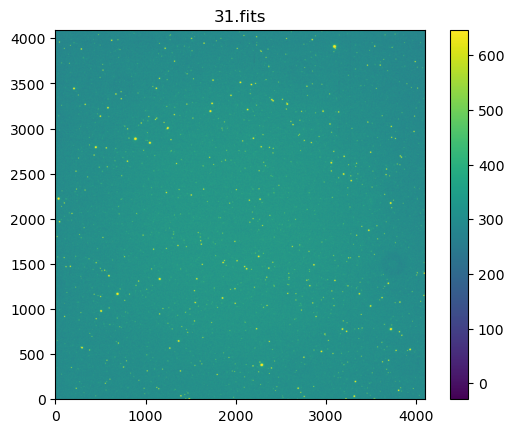

In [76]:
frame31 = astropy.nddata.CCDData.read("data/science_B_cali/20181101.00000031.fits", unit="adu")
plt.imshow(frame31, vmin=-29.470348, vmax=646.92706)
plt.gca().invert_yaxis()
plt.title("31.fits")
plt.colorbar()
plt.show()

In [71]:
array31 = np.asarray(frame31)
x = len(array31)
y = len(array31[0])
print(f"Dimensions = {x}x{y} pixels")

#I found the largest star to be ~40x40 pix so chose the bigbox to be 64x64

Dimensions = 4096x4096 pixels


Background Median = 310.0 adu
Background rms = 59.84645364707618 adu


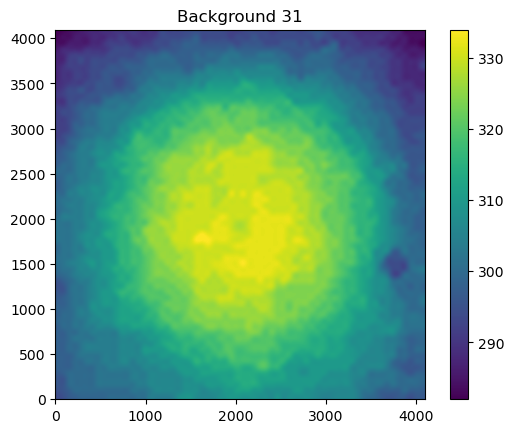

In [80]:
bg31 = photobg.Background2D(frame31, 64, filter_size=3, bkg_estimator=MedianBackground())
bgmedian = bg31.background_median
bgrms = bg31.background_rms_median
print(f"Background Median = {bgmedian}")
print(f"Background rms = {bgrms}")

bgimg = bg31.background

plt.imshow(np.asarray(bgimg), interpolation="nearest")
plt.gca().invert_yaxis()
plt.title("Background 31")
plt.colorbar()
plt.show()

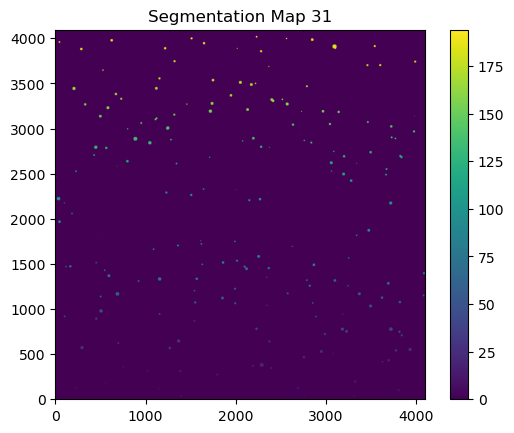

<photutils.segmentation.core.SegmentationImage>
shape: (4096, 4096)
nlabels: 194
labels: [  1   2   3   4   5 ... 190 191 192 193 194]


In [85]:
gaussiankernal = photoseg.make_2dgaussian_kernel(25, 25)
threshold = bgimg + 2 * bgrms
convolved_data = convolve(frame31, gaussiankernal) * u.adu
segment_map = photoseg.detect_sources(convolved_data, threshold, npixels=5)

plt.imshow(segment_map)
plt.gca().invert_yaxis()
plt.title("Segmentation Map 31")
plt.colorbar()
plt.show()

print(segment_map)

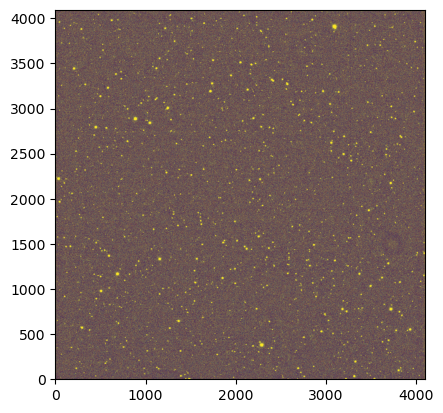

In [82]:
bglessframe = np.asarray(frame31) - np.asarray(bgimg)

plt.imshow(bglessframe, vmin=0, vmax=50)
plt.title("Background Removed Frame 31")
plt.gca().invert_yaxis()
plt.show()

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


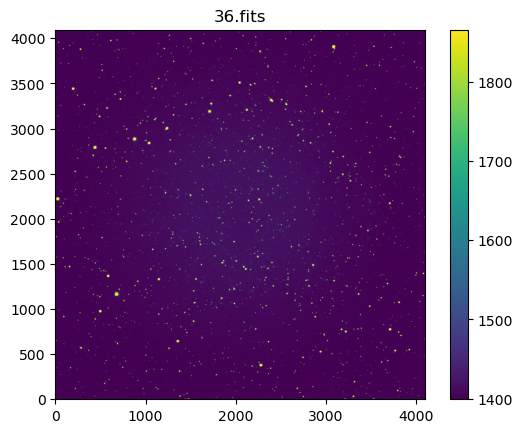

In [86]:
frame36 = astropy.nddata.CCDData.read("data/science_R_cali/20181101.00000036.fits", unit="adu")
plt.imshow(frame36, vmin=1399.2028, vmax=1865.4568)
plt.gca().invert_yaxis()
plt.title("36.fits")
plt.colorbar()
plt.show()

Background Median = 1288.0000000000002 adu
Background rms = 71.79759701888088 adu


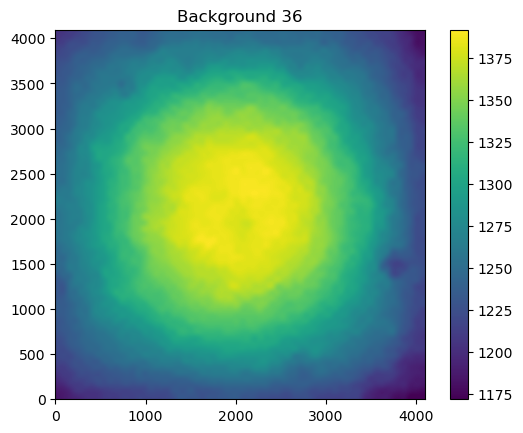

In [87]:
bg36 = photobg.Background2D(frame36, 64, filter_size=3, bkg_estimator=MedianBackground())
bgmedian = bg36.background_median
bgrms = bg36.background_rms_median
print(f"Background Median = {bgmedian}")
print(f"Background rms = {bgrms}")

bgimg = bg36.background

plt.imshow(np.asarray(bgimg), interpolation="nearest")
plt.gca().invert_yaxis()
plt.title("Background 36")
plt.colorbar()
plt.show()

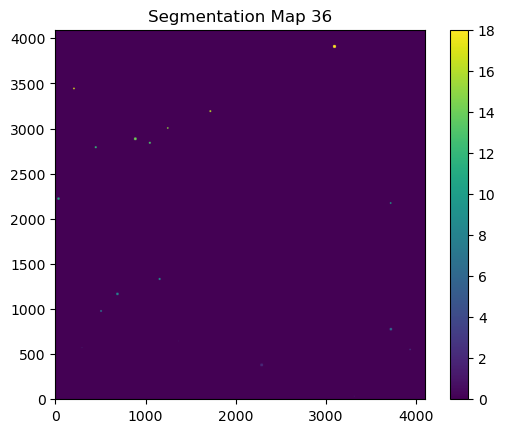

<photutils.segmentation.core.SegmentationImage>
shape: (4096, 4096)
nlabels: 18
labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [88]:
gaussiankernal = photoseg.make_2dgaussian_kernel(25, 25)
threshold = bgimg + 2 * bgrms
convolved_data = convolve(frame31, gaussiankernal) * u.adu
segment_map = photoseg.detect_sources(convolved_data, threshold, npixels=5)

plt.imshow(segment_map)
plt.gca().invert_yaxis()
plt.title("Segmentation Map 36")
plt.colorbar()
plt.show()

print(segment_map)

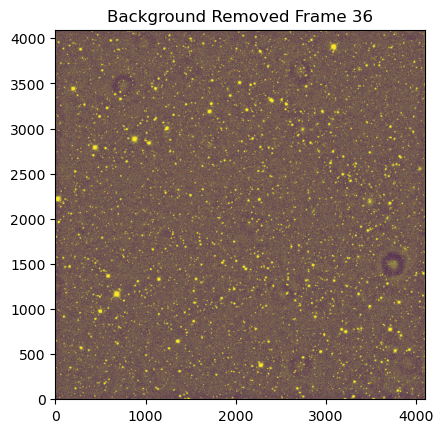

In [90]:
bglessframe = np.asarray(frame36) - np.asarray(bgimg)

plt.imshow(bglessframe, vmin=0, vmax=50)
plt.title("Background Removed Frame 36")
plt.gca().invert_yaxis()
plt.show()